In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
# from sklearn.model_selection import cross_validate
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import r2_score
# import torch.nn as nn
# from torch.nn import ReLU, Sigmoid
# from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
# import torch
# from torch.utils.tensorboard import SummaryWriter
from pycaret.regression import *

In [3]:
proteins = pd.read_csv('../data/train_proteins.csv')
proteins.head()


,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [4]:
npx_features = pd.pivot(proteins, index='visit_id',
                        values='NPX', columns='UniProt')


In [5]:
npx_features = npx_features.fillna(0)


<Axes: xlabel='UniProt', ylabel='UniProt'>

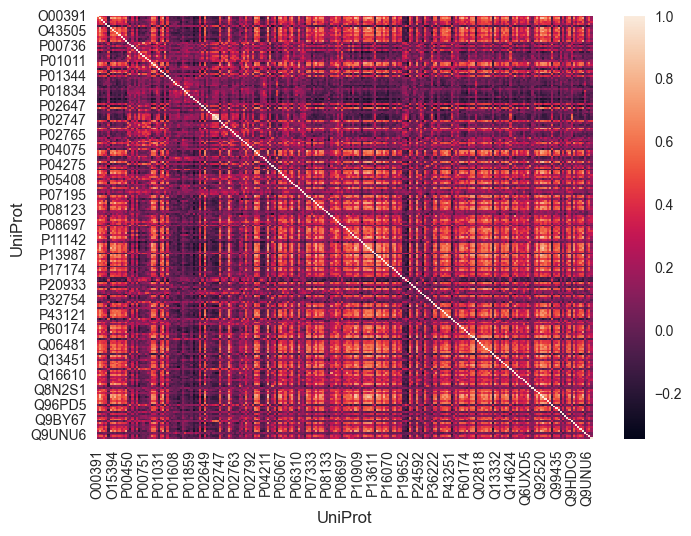

In [6]:
sns.heatmap(npx_features.corr())


In [7]:
clinical_data = pd.read_csv('../data/train_clinical_data.csv')
clinical_data.set_index('visit_id', inplace=True)
clinical_data.head()


,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
visit_id,,,,,,,
55_0,55,0,10.0,6.0,6,NaN,NaN
55_3,55,3,10.0,7.0,19,NaN,NaN
55_6,55,6,8.0,10.0,58,NaN,NaN
55_9,55,9,8.0,9.0,17,0.0,On
55_12,55,12,10.0,10.0,2,0.0,On


In [8]:
li = []
for idx, v in enumerate(clinical_data.index.values):
    parts = v.split('_')
    if parts[1] == '0':
        li.append('00000')
    else:
        li.append(clinical_data.index.values[idx-1])


def offset_updrs2(row):
    if (row['offset'] == '00000'):
        return 0
    else:
        return clinical_data.loc[row['offset']]['updrs_2']


def offset_updrs1(row):
    if (row['offset'] == '00000'):
        return 0
    else:
        return clinical_data.loc[row['offset']]['updrs_1']


clinical_data['offset'] = li

clinical_data['offset_updrs2_offset'] = clinical_data.apply(
    offset_updrs2, axis=1)
clinical_data['offset_updrs1_offset'] = clinical_data.apply(
    offset_updrs1, axis=1)


def smape(a, b):
    return 100*pd.Series(abs((a-b)/((a+b)/2))).fillna(0).sum()/len(a)


clinical_data.fillna(0, inplace=True)


In [9]:
clinical_data = clinical_data[clinical_data['upd23b_clinical_state_on_medication'] == 0][[
    'updrs_1', 'updrs_2', 'offset_updrs2_offset', 'offset_updrs1_offset', 'updrs_3', 'updrs_4']]


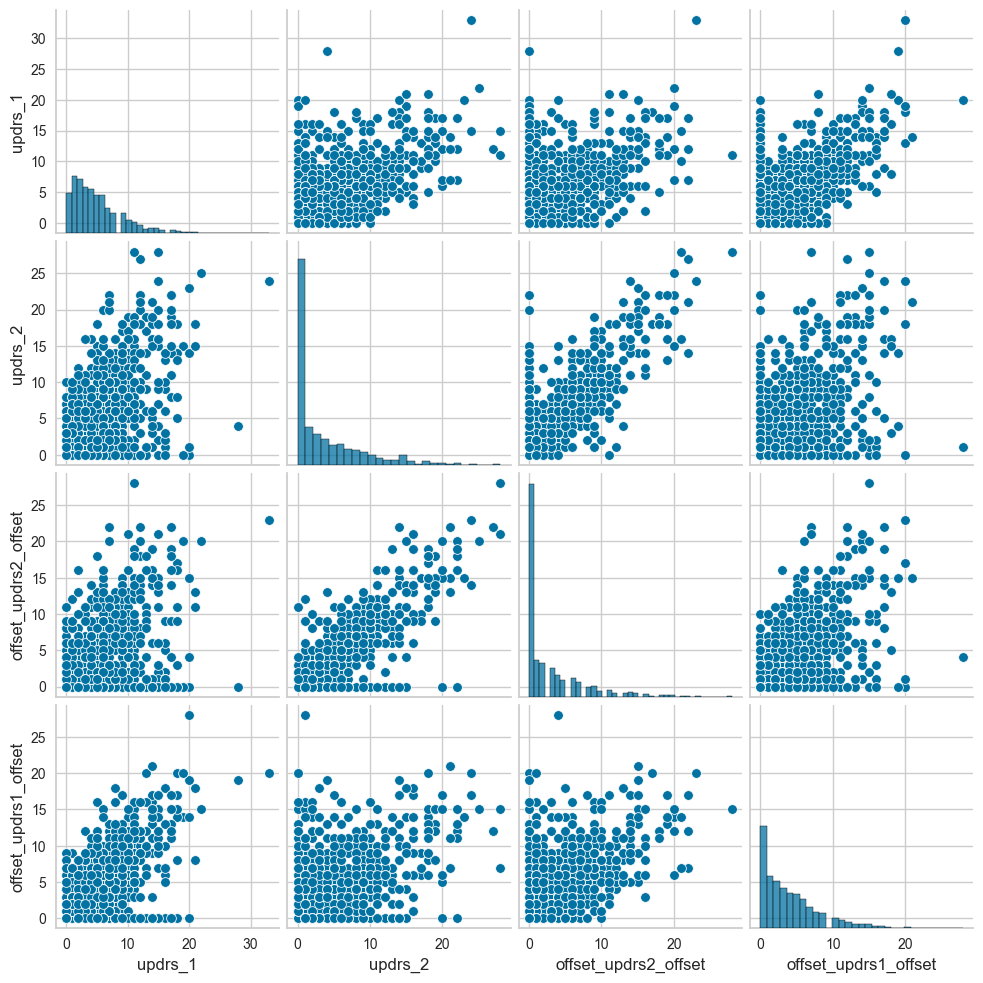

In [10]:
sns.pairplot(clinical_data[['updrs_1', 'updrs_2',
             'offset_updrs2_offset', 'offset_updrs1_offset']])


In [11]:
dataset = pd.merge(clinical_data[['updrs_2', 'offset_updrs2_offset', 'offset_updrs1_offset']],
                   npx_features, how='inner', left_on=['visit_id'], right_on=['visit_id'])
dataset.head()


,updrs_2,offset_updrs2_offset,offset_updrs1_offset,O00391,O00533,O00584,O14498,O14773,O14791,O15240,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
visit_id,,,,,,,,,,,,,,,,,,,,,
55_0,6.0,0.0,0.0,11254.30,732430.0,39585.8,41526.9,31238.00,4202.71,177775.0,...,365475.0,35528.0,97005.6,23122.5,60912.6,408698.0,0.0,29758.8,23833.7,18953.5
55_6,10.0,7.0,10.0,13163.60,630465.0,35220.8,41295.0,26219.90,4416.42,165638.0,...,405676.0,30332.6,109174.0,23499.8,51655.8,369870.0,0.0,22935.2,17722.5,16642.7
942_6,2.0,2.0,7.0,11218.70,399518.0,20581.0,31290.9,6173.58,2564.37,160526.0,...,253373.0,27431.8,93796.7,17450.9,21299.1,306621.0,82335.5,24018.7,18939.5,15251.2
942_12,2.0,2.0,8.0,6757.32,360858.0,18367.6,14760.7,18603.40,1722.77,86847.4,...,45742.3,33518.6,94049.7,13415.7,21324.7,234094.0,82410.4,19183.7,17804.1,12277.0
942_24,3.0,5.0,6.0,0.00,352722.0,22834.9,23393.1,16693.50,1487.91,114772.0,...,180475.0,29770.6,95949.9,11344.4,23637.6,256654.0,76931.9,19168.2,19215.9,14625.6


In [12]:
peptides = pd.read_csv('../data/train_peptides.csv')
peptides.head()


,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


In [13]:
p = peptides.pivot_table(values='PeptideAbundance',
                         columns='Peptide', index=['visit_id', 'UniProt'])


In [14]:
p.fillna(0, inplace=True)


In [17]:

class ParkinsonDataSet(Dataset):
    def __init__(self, clinical_data=clinical_data, npx_data=npx_features, peptide_data=p) -> None:
        self.c = clinical_data
        self.n = npx_data
        self.p = p
        self.ids = self.n.index.unique()
        self.proteins= self.n.columns
        self.peptides = self.p.columns

    def __len__(self):
        return len(self.c)

    def __getitem__(self, idx):
        patient_id = self.ids[idx]
        patient_peptides = self.p.loc[patient_id]
        features = []
        protein_peptides = []
        for protein in self.proteins:
            peps = None
            if (patient_id, protein) in self.p.index:
                peps = patient_peptides.loc[protein].values
            else:
                peps = np.zeros(968)
            protein_peptides.extend(peps)
        features.extend(protein_peptides)
        try:
            features.extend([self.c.loc[patient_id]['offset_updrs1_offset'],
                            self.c.loc[patient_id]['offset_updrs2_offset']])
            labels = [self.c.loc[patient_id]['updrs_1'], self.c.loc[patient_id]['updrs_2'],
                    self.c.loc[patient_id]['updrs_2'], self.c.loc[patient_id]['updrs_3']]
            return np.array(features), np.array(labels)
        except:
            return None


In [18]:
pds = ParkinsonDataSet()
#dataloader = DataLoader(pds, batch_size=1, num_workers=0)
d = np.zeros(219738)
l = np.zeros(4)
for tup in tqdm(pds):
    if tup:
        d= np.vstack((d,tup[0]))
        l=np.vstack((l,tup[1]))

 84%|██████████████████████████████████████████████████████████████████████████████████████▍                | 1113/1327 [02:14<00:25,  8.26it/s]


In [19]:
d = d[1:]
l = l[1:]

In [43]:
unscaled_d = d.T[219736:].T
scalable_d = d.T[:219736].T

In [44]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=0.9))
])

transform_d = pipe.fit_transform(scalable_d)

In [46]:
final_d = np.hstack((transform_d,unscaled_d))

# UPDRS2 performance with all of the PCA features 

In [47]:
s = setup(data=transform_d, target=l.T[1])

,Description,Value
0,Session id,2861
1,Target,target
2,Target type,Regression
3,Original data shape,"(616, 174)"
4,Transformed data shape,"(616, 174)"
5,Transformed train set shape,"(431, 174)"
6,Transformed test set shape,"(185, 174)"
7,Numeric features,173
8,Preprocess,True
9,Imputation type,simple


In [48]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,3.3811,22.3358,4.5978,0.0878,1.0461,0.7912,0.1120
en,Elastic Net,3.3836,22.5708,4.6178,0.0802,1.0422,0.7799,0.1610
lightgbm,Light Gradient Boosting Machine,3.3998,23.3314,4.6812,0.0523,1.0447,0.8702,0.2030
gbr,Gradient Boosting Regressor,3.4624,23.4363,4.7053,0.0409,1.0551,0.8795,0.6500
ada,AdaBoost Regressor,3.7370,23.4334,4.7293,0.0310,1.1401,0.8866,0.2260
et,Extra Trees Regressor,3.5561,23.9246,4.7491,0.0250,1.0919,0.8284,0.2940
lasso,Lasso Regression,3.5627,24.1011,4.7788,0.0198,1.0841,0.7824,0.1220
llar,Lasso Least Angle Regression,3.5627,24.1011,4.7788,0.0198,1.0841,0.7824,0.1270
omp,Orthogonal Matching Pursuit,3.5509,24.3158,4.8080,-0.0059,1.0721,0.8899,0.1130
dummy,Dummy Regressor,3.6594,25.1030,4.8808,-0.0222,1.1115,0.7737,0.1230


In [28]:
Y = dataset[dataset.columns[0]].values
X = dataset[dataset.columns[3:]].values
X_noscale = dataset[dataset.columns[1:3]].values


In [31]:
dataset.head(1)

,updrs_2,offset_updrs2_offset,offset_updrs1_offset,O00391,O00533,O00584,O14498,O14773,O14791,O15240,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
visit_id,,,,,,,,,,,,,,,,,,,,,
55_0,6.0,0.0,0.0,11254.3,732430.0,39585.8,41526.9,31238.0,4202.71,177775.0,...,365475.0,35528.0,97005.6,23122.5,60912.6,408698.0,0.0,29758.8,23833.7,18953.5


In [29]:
X_scaled = StandardScaler().fit_transform(X)
final_X = np.hstack((X_noscale, X_scaled))


# UPDRS 2 Predictions with just protein data

In [32]:
s = setup(data=final_X, target=Y)

,Description,Value
0,Session id,360
1,Target,target
2,Target type,Regression
3,Original data shape,"(616, 230)"
4,Transformed data shape,"(616, 230)"
5,Transformed train set shape,"(431, 230)"
6,Transformed test set shape,"(185, 230)"
7,Numeric features,229
8,Preprocess,True
9,Imputation type,simple


In [33]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,2.1224,9.2974,3.0050,0.5802,0.7616,0.5583,0.0980
et,Extra Trees Regressor,2.0799,9.0739,2.9866,0.5768,0.7329,0.5981,0.3730
br,Bayesian Ridge,2.1027,9.2343,3.0108,0.5749,0.7435,0.6023,0.1360
lasso,Lasso Regression,2.1526,9.4430,3.0281,0.5734,0.7751,0.5689,0.1220
llar,Lasso Least Angle Regression,2.1526,9.4428,3.0281,0.5734,0.7751,0.5689,0.1260
rf,Random Forest Regressor,2.0996,9.3990,3.0463,0.5585,0.7433,0.5964,1.2680
lightgbm,Light Gradient Boosting Machine,2.1295,9.8443,3.1107,0.5360,0.7415,0.6387,0.3460
omp,Orthogonal Matching Pursuit,2.2595,10.3456,3.1741,0.5236,0.7880,0.6660,0.1240
gbr,Gradient Boosting Regressor,2.1534,10.1923,3.1686,0.5124,0.7524,0.6092,0.9790
ada,AdaBoost Regressor,2.6789,11.3033,3.3423,0.4845,0.9636,0.6539,0.3300


ElasticNet(random_state=360)

# NeURaL NeTWorK

In [ ]:
class BrownMunde(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight_layer = nn.Linear(968, 227)
        self.attention_layer = nn.Linear(227, 4)
        self.merge_layer = nn.Linear(227,1)
        self.relu = ReLU()
        self.sigmoid = Sigmoid()

    def forward(self, pp):
        x1 = self.relu(self.weight_layer(pp))[0]
        x1 = self.relu(self.attention_layer(x1))
        x1 = self.relu(self.merge_layer(x1.T))
        return self.relu(x1)


In [ ]:
# updrs 2
model = BrownMunde()
loss_f = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=4e-4)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

train_list = []

model.to(device)

writer = SummaryWriter()

l = 0
for epoch in range(2):
    for step, data in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()
        pp, up, y = data
        output = model(pp.float())
        print(output)
        loss = loss_f(output, y.float())
        l += loss
        loss.backward()
        optimizer.step()

        if (step/50 > 0) & (step % 50 == 0):
            writer.add_scalar("BM Loss/Step", l, (epoch*len(dataloader)+step))
            l = 0


In [ ]:
d_test = DataLoader(X_test, batch_size=1)  # , shuffle=True)
output_list = []
with torch.no_grad():
    for step, data in tqdm(enumerate(d_test)):
        output = model(data.to(device).float())
        output_list.append(torch.round(output.detach()).cpu().numpy()[0][0])
output_list = np.array(output_list)


In [ ]:
r2_score(Y_test, output_list), smape(output_list, Y_test)


In [ ]:
sns.scatterplot(x=Y_test, y=output_list)


In [ ]:
dataset.corr()['updrs_2']


In [ ]:
peptides = pd.read_csv('../data/train_peptides.csv')
peptides.head()


In [ ]:
len(peptides['Peptide'].unique())


In [ ]:
peptides.groupby('UniProt')['Peptide'].value_counts()


In [ ]:
import pycaret

from pycaret.regression import *

s = setup(dataset, target='updrs_2')


In [ ]:
best = compare_models()


In [ ]:
best


In [ ]:
tune_model(best)


In [ ]:
plot_model
